##Assignment 5 Autoencoders
Name: Jonathan Au <br>
Student #: 300827701 <br>

In this assignment, you will implement an autoencoder that encodes and decodes data using the Olivetti faces dataset.
1.	Use the training set, validation set, and test set from Assignment 3 (Hierarchical Clustering) for this Assignment. [0 points]
2.	Use PCA preserving 99% of the variance to reduce the dataset’s dimensionality as in Assignment 4 (Gaussian Mixture Models) and use it to train the autoencoder [0 points]
3.	Define an autoencoder with the following architecture:        
       
       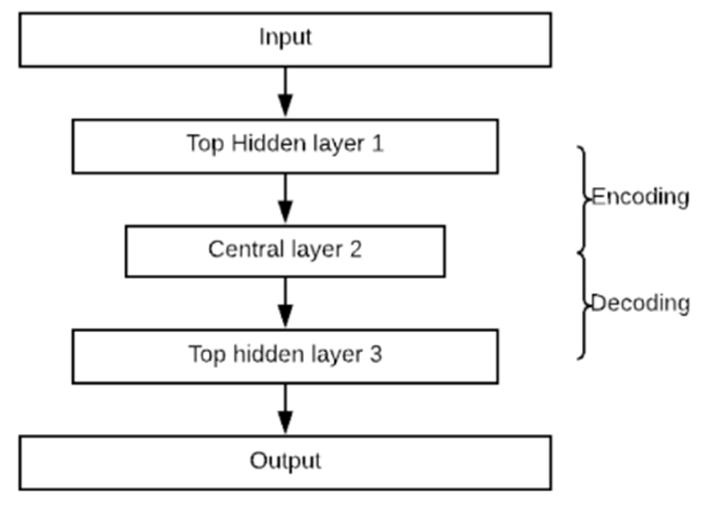
       <br>
	a) Use k-fold cross validation to fine tune the model’s learning rate and hyperparameter of the regularizer.  Due to the long training requirements, for the number of hidden units, try two or three different values for each hidden layer. [75 points]<br>
	b) Discuss the rationale with respect to the activation functions and loss function used in your model. [10 points]<br>

Run the best model with the test set and display the original image and the reconstructed image. [15 points]


!pip uninstall tensorflow <br>
!pip install tensorflow==2.17.0

In [14]:
#All imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from numpy.linalg import eig
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.datasets import fetch_olivetti_faces
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering
from tensorflow.keras.models import load_model, Model
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dense, Input
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, KFold

import warnings
warnings.filterwarnings("ignore")

1.	Use the training set, validation set, and test set from Assignment 3 (Hierarchical Clustering) for this Assignment. [0 points]

In [15]:
# Load olivetti faces
olivetti = fetch_olivetti_faces()
#X = olivetti.data
#Y = olivetti.target
#Z = olivetti.images

X = pd.DataFrame(olivetti["data"])
Y = pd.DataFrame(olivetti["target"])

# Print the description and shapes of the dataset
#print(olivetti.DESCR)
print(X.shape)
print(Y.shape)
#print(Z.shape)

#split into train and test data
X_train, X_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=.665)

#split train data into train and validation data
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5)

#print the shapes of the data
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(400, 4096)
(400, 1)
(134, 4096)
(133, 4096)
(133, 4096)


2.	Use PCA preserving 99% of the variance to reduce the dataset’s dimensionality as in Assignment 4 (Gaussian Mixture Models) and use it to train the autoencoder [0 points]

In [16]:
# Create PCA instance
# set PCA to get 99% of variance
pca = PCA(n_components=0.99)

# Fit train data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
pc = pca.fit_transform(X_train_scaled)

X_train_pca = pd.DataFrame(pca.fit_transform(X_train))


# Print the number of components and the explained variance ratio
print ( "Components =", pca.n_components_ , "\nTotal explained variance =",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components = 108 
Total explained variance = 0.99016


3. Define an autoencoder with the following architecture: <br><b>
Input -> Top Hidden: Layer 1 -> Central: Layer 2 -> Top Hidden: Layer 3 -> Output <br></b>
Encoding: Top Hidden: Layer 1 -> Central: Layer 2 <br>
Decoding: Central: Layer 2 -> Top Hidden: Layer 3<br>


In [17]:
# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*2)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
autoencode = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
autoencode.compile(optimizer='adam', loss='mse')


In [18]:
autoencode.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 8192)                │      33,562,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2048)                │       8,390,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4096)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 8192)                │      33,562,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4096)                │      33,558,528 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,123,968 (576.49 MB)

 Trainable params: 151,074,816 (576.30 MB)

 Non-trainable params: 49,152 (192.00 KB)

  a) Use k-fold cross validation to fine tune the model’s learning rate and hyperparameter of the regularizer. <br>Due to the long training requirements, for the number of hidden units, try two or three different values for each hidden layer. [75 points]

In [22]:
#Use K-fold for cross val
kFoldCV = KFold(n_splits=2)
kFoldCV.get_n_splits(X)
print(kFoldCV)

history = autoencode.fit(X_train, y_train, epochs=10, batch_size=16, verbose=2, validation_data=(X_test, y_test))
#print("K Fold CV: \n", history)

#Training classifier for prediction

#y_pred = cross_val_predict(kmean, X_train, y_train, cv=kFoldCV)
#y_pred = cross_val_predict(LogisticRegression(), X_train, y_train, cv=kFoldCV)
#y_pred = cross_val_predict(RandomForestRegressor(), X_train, y_train, cv=kFoldCV)
#print("Y Prediction: ", y_pred)

#score = cross_val_score(LogisticRegression(), X_train, y_train, cv=kFoldCV)
#score = cross_val_score(RandomForestRegressor(), X_train, y_train, cv=kFoldCV)
#print("Score: ", score)

KFold(n_splits=2, random_state=None, shuffle=False)
Epoch 1/10
9/9 - 35s - 4s/step - loss: 77.6099 - val_loss: 112966.3828
Epoch 2/10
9/9 - 35s - 4s/step - loss: 88.5696 - val_loss: 138996.1562
Epoch 3/10
9/9 - 40s - 4s/step - loss: 75.4526 - val_loss: 31967.2227
Epoch 4/10
9/9 - 41s - 5s/step - loss: 71.5170 - val_loss: 20060.3633
Epoch 5/10
9/9 - 28s - 3s/step - loss: 55.4408 - val_loss: 24091.0508
Epoch 6/10
9/9 - 42s - 5s/step - loss: 37.5275 - val_loss: 6735.7061
Epoch 7/10
9/9 - 41s - 5s/step - loss: 34.3274 - val_loss: 450.9838
Epoch 8/10
9/9 - 41s - 5s/step - loss: 33.7179 - val_loss: 553.8448
Epoch 9/10
9/9 - 41s - 5s/step - loss: 43.2109 - val_loss: 288.5405
Epoch 10/10
9/9 - 41s - 5s/step - loss: 26.7766 - val_loss: 536.7541
K Fold CV: 


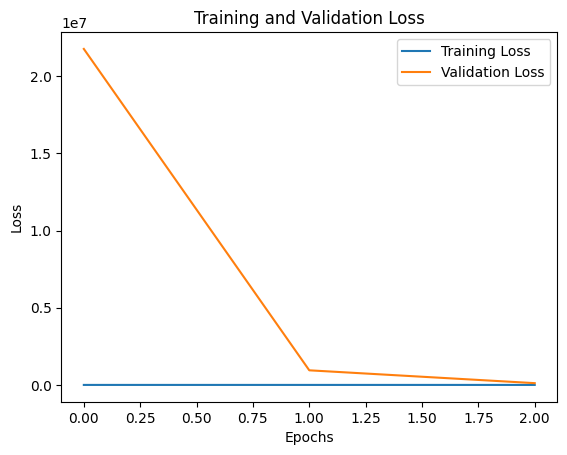

In [20]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

  b) Discuss the rationale with respect to the activation functions and loss function used in your model. [10 points]
<br><br>
From the graph, it can be seen that the greater the epoch, the lower the loss.

Run the best model with the test set and display the original image and the reconstructed image. [15 points]

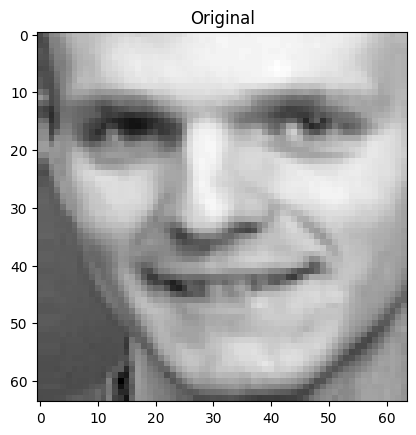

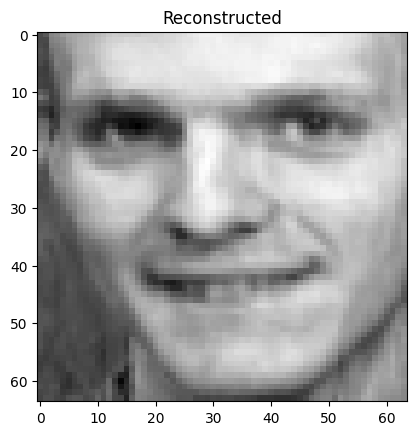

In [21]:
plt.title("Original")
plt.imshow(np.array(X_train.iloc[0]).reshape(64,64), cmap="gray")
plt.show()

# generating New faces with Sample()
model = pd.DataFrame(pca.inverse_transform(X_train_pca))

plt.title("Reconstructed")
plt.imshow(np.array(model.iloc[0]).reshape(64,64), cmap="gray")
plt.show()